<div class="alert alert-block alert-info">
<font size="5"><b><center> Section 5</font></center>
<br>
<font size="5"><b><center>Recurrent Neural Network in PyTorch with an Introduction to Natural Language Processing</font></center>
</div>

Credit: This example is obtained from the following book:

Subramanian, Vishnu. 2018. "*Deep Learning with PyTorch: A Practical Approach to Building Neural Network Models Using PyTorch.*" Birmingham, U.K., Packt Publishing.

# Simple Text Processing

## Typically Data Preprocessing Steps before Modeling Training for NLP Applications

* Read the data from disk
* Tokenize the text
* Create a mapping from word to a unique integer
* Convert the text into lists of integers
* Load the data in whatever format your deep learning framework requires
* Pad the text so that all the sequences are the same length, so you can process them in batch

## Word Embedding

Word embedding is a very popular way of representing text data in problems that are solved by deep learning algorithms

Word embedding provides a dense representation of a word filled with floating numbers. 

It drastically reduces the dimension of the dictionary



###  `Torchtext` and Training word embedding by building a sentiment classifier

Torchtext takes a declarative approach to loading its data: 

  * you tell torchtext how you want the data to look like, and torchtext handles it for you
  
  * Declaring a Field: The Field specifies how you want a certain field to be processed
  
The `Field` class is a fundamental component of torchtext and is what makes preprocessing very easy



### Load `torchtext.datasets`

# Use LSTM for Sentiment Classification

1. Preparing the data
2. Creating the batches 
3. Creating the network 
4. Training the model

In [1]:
from torchtext import data, datasets
from torchtext.vocab import GloVe,FastText,CharNGram

TEXT = data.Field(lower=True, fix_length=100,batch_first=False)
LABEL = data.Field(sequential=False,)

train, test = datasets.imdb.IMDB.splits(TEXT, LABEL)

TEXT.build_vocab(train, vectors=GloVe(name='6B', dim=300),max_size=10000,min_freq=10)
LABEL.build_vocab(train,)

In [2]:
len(TEXT.vocab.vectors)

10002

In [3]:
train_iter, test_iter = data.BucketIterator.splits((train, test), batch_size=32, device=-1)
train_iter.repeat = False
test_iter.repeat = False

The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


In [4]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

In [5]:
class IMDBRnn(nn.Module):
    
    def __init__(self,vocab,hidden_size,n_cat,bs=1,nl=2):
        super().__init__()
        self.hidden_size = hidden_size
        self.bs = bs
        self.nl = nl
        self.e = nn.Embedding(n_vocab,hidden_size)
        self.rnn = nn.LSTM(hidden_size,hidden_size,nl)
        self.fc2 = nn.Linear(hidden_size,n_cat)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self,inp):
        bs = inp.size()[1]
        if bs != self.bs:
            self.bs = bs
        e_out = self.e(inp)
        h0 = c0 = Variable(e_out.data.new(*(self.nl,self.bs,self.hidden_size)).zero_())
        rnn_o,_ = self.rnn(e_out,(h0,c0))
        rnn_o = rnn_o[-1]
        fc = F.dropout(self.fc2(rnn_o),p=0.8)
        return self.softmax(fc)

In [6]:
n_vocab = len(TEXT.vocab)
n_hidden = 100

In [7]:
model = IMDBRnn(n_vocab,n_hidden,n_cat=3,bs=32)
#model = model.cuda()

optimizer = optim.Adam(model.parameters(),lr=1e-3)

def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , batch in enumerate(data_loader):
        text , target = batch.text , batch.label
#         if is_cuda:
#             text,target = text.cuda(),target.cuda()
        
        if phase == 'training':
            optimizer.zero_grad()
        output = model(text)
        loss = F.nll_loss(output,target)
        
        #running_loss += F.nll_loss(output,target,size_average=False).data[0]
        running_loss += F.nll_loss(output,target,size_average=False).data
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    print("epoch: ", epoch, "loss: ", loss, "accuracy: ", accuracy)
    #print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [8]:
import time
start = time.time()

train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]

for epoch in range(1,20):

    epoch_loss, epoch_accuracy = fit(epoch,model,train_iter,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,test_iter,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    
end = time.time()
print((end-start)/60)
print("Execution Time: ", round(((end-start)/60),1), "minutes")

/Users/jeffrey/anaconda2/envs/dl/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch:  1 loss:  tensor(1.0033) accuracy:  tensor(49)
epoch:  1 loss:  tensor(1.0032) accuracy:  tensor(49)
epoch:  2 loss:  tensor(0.9953) accuracy:  tensor(50)
epoch:  2 loss:  tensor(1.0013) accuracy:  tensor(50)
epoch:  3 loss:  tensor(1.0006) accuracy:  tensor(50)
epoch:  3 loss:  tensor(1.0029) accuracy:  tensor(49)
epoch:  4 loss:  tensor(1.0017) accuracy:  tensor(49)
epoch:  4 loss:  tensor(1.0013) accuracy:  tensor(50)
epoch:  5 loss:  tensor(0.9996) accuracy:  tensor(49)
epoch:  5 loss:  tensor(1.0014) accuracy:  tensor(49)
epoch:  6 loss:  tensor(1.0021) accuracy:  tensor(49)
epoch:  6 loss:  tensor(0.9967) accuracy:  tensor(50)
epoch:  7 loss:  tensor(0.9996) accuracy:  tensor(50)
epoch:  7 loss:  tensor(1.0007) accuracy:  tensor(50)
epoch:  8 loss:  tensor(0.9939) accuracy:  tensor(51)
epoch:  8 loss:  tensor(0.9715) accuracy:  tensor(54)
epoch:  9 loss:  tensor(0.9452) accuracy:  tensor(57)
epoch:  9 loss:  tensor(0.9408) accuracy:  tensor(57)
epoch:  10 loss:  tensor(0.9

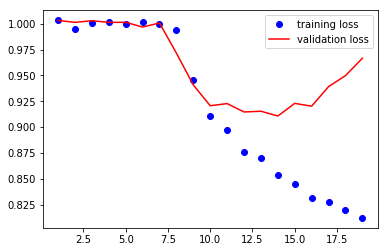

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

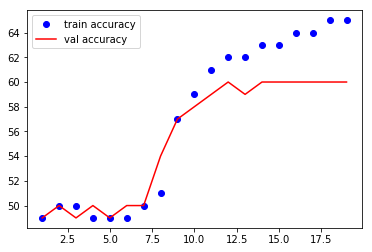

In [10]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()